### DOT

In [83]:
import torch.nn.functional as F
from torch_explain.nn.concepts import ConceptReasoningLayer, IntpLinearLayer1, IntpLinearLayer2, IntpLinearLayer3
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch_explain as te
from torch_explain import datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

%matplotlib inline
import logging
import warnings
warnings.filterwarnings('ignore')
# Set the logging level for matplotlib to WARNING to suppress debug information
logging.getLogger('matplotlib').setLevel(logging.WARNING)


PATH = 'models/'

In [84]:
from torch_explain.datasets import dot
x, c, y = dot(10000)

In [85]:
y = F.one_hot(y.long().ravel()).float()

LLR 1

In [86]:
isBias = True

In [87]:
embedding_size = 16
concept_encoder = torch.nn.Sequential(
    torch.nn.Linear(x.shape[1], 16),
    torch.nn.LeakyReLU(),
    te.nn.ConceptEmbedding(16, c.shape[1], embedding_size),
)

task_predictor = IntpLinearLayer1(embedding_size, y.shape[1], bias=isBias)
model = torch.nn.Sequential(concept_encoder, task_predictor)

In [88]:
import os
model.load_state_dict(torch.load(os.path.join(PATH,'model_state_dict_LLR1_DOT_3.pth')))

<All keys matched successfully>

In [89]:
cem = model[0]
llr = model[1]
cem.eval()
llr.eval()
c_emb , c_pred = cem(x)
y_pred, weights, biases = llr(c_emb, c_pred, return_params=True)

In [90]:
y_pred.shape, weights.shape, biases.shape

(torch.Size([10000, 2]), torch.Size([10000, 2, 2]), torch.Size([10000, 2]))

In [91]:
df_all = pd.DataFrame()
df_all['c0'] = c[:,0].detach().numpy()
df_all['c1'] = c[:,1].detach().numpy()
df_all['w0_y0'] = weights[:,0,0].detach().numpy()
df_all['w1_y0'] = weights[:,1,0].detach().numpy()
df_all['w0_y1'] = weights[:,0,1].detach().numpy()
df_all['w1_y1'] = weights[:,1,1].detach().numpy()
df_all['b_y0'] = biases[:,0].detach().numpy()
df_all['b_y1'] = biases[:,1].detach().numpy()
df_all['y0'] = y[:,0].detach().numpy()
df_all['y1'] = y[:,1].detach().numpy()
df_all['y_pred0'] = y_pred[:,0].detach().numpy()
df_all['y_pred1'] = y_pred[:,1].detach().numpy()

In [92]:
temp = df_all[['y_pred0', 'y_pred1']].apply(lambda x: torch.sigmoid(torch.tensor([x[0], x[1]])).numpy(), axis=1).to_numpy()
arr_as_list = [list(sub_array) for sub_array in temp]
arr_converted = np.array(arr_as_list)
column_0 = arr_converted[:, 0]
column_1 = arr_converted[:, 1]

df_all['y_pred0'] = column_0
df_all['y_pred1'] = column_1

In [93]:
df_all.head()

,c0,c1,w0_y0,w1_y0,w0_y1,w1_y1,b_y0,b_y1,y0,y1,y_pred0,y_pred1
0,1.0,0.0,0.000362,0.013568,0.999639,0.982975,-2.477407,1.778839,0.0,1.0,0.077483,0.941486
1,1.0,1.0,0.010318,0.002126,0.987464,0.996933,-1.702966,0.413704,0.0,1.0,0.155707,0.916652
2,0.0,1.0,0.000151,0.005905,0.999706,0.994274,-2.508945,1.769732,0.0,1.0,0.075645,0.940700
3,1.0,1.0,0.999712,0.999967,0.000125,0.000006,2.392825,-3.921264,1.0,0.0,0.987781,0.019433
4,1.0,0.0,0.000003,0.000002,0.999996,0.999999,-4.536963,3.907485,0.0,1.0,0.010593,0.991625


In [94]:
df0= df_all[['c0', 'c1', 'w0_y0', 'w1_y0', 'b_y0']][df_all['y_pred0'] > 0.5]
df1= df_all[['c0', 'c1', 'w0_y1', 'w1_y1', 'b_y1']][df_all['y_pred1'] > 0.5]

In [95]:
df0_mean = df0[['w0_y0', 'w1_y0', 'b_y0']].mean(axis=0)
df0_mean

w0_y0    0.945836
w1_y0    0.907386
b_y0     2.118506
dtype: float32

In [96]:
df1_mean = df1[['w0_y1', 'w1_y1', 'b_y1']].mean(axis=0)
df1_mean

w0_y1    0.938679
w1_y1    0.960583
b_y1     2.629308
dtype: float32

In [97]:
import random
def plotting_function(df_1, title):

    fig, ax = plt.subplots()

    def softmax(x):
        return np.exp(x) / np.sum(np.exp(x), axis=0)

    # Assuming df_1 is correctly calculated before this snippet
    bar_width = 0.5
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Custom colors for each bar
    colors = random.sample(colors, len(df_1))
    hatches = ['/', '-', '|', '\\']  # Different hatches for each bar
    hatches = random.sample(hatches, len(df_1))
    bars = ax.bar(df_1.index, softmax(df_1), bar_width, color=colors, edgecolor='black')

    for bar, hatch in zip(bars, hatches):
        bar.set_hatch(hatch)
        
    ax.set_ylabel('Mean Absolute Value')
    ax.set_title(title)
    ax.grid(True, linestyle='--', which='major', color='gray', alpha=0.5)
    ax.set_ylim([0, 0.6])

    # Enhanced label positioning
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.03, f'{yval:.2f}', ha='center', va='bottom', fontsize=9, color='black')

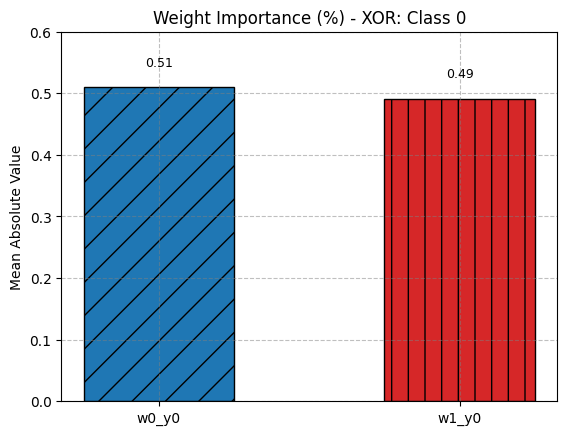

In [99]:
plotting_function(df0_mean[['w0_y0', 'w1_y0']], title="Weight Importance (%) - XOR: Class 0")

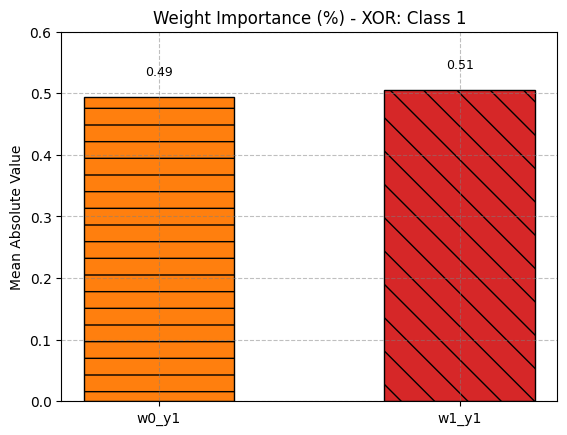

In [100]:
plotting_function(df1_mean[['w0_y1', 'w1_y1']], title="Weight Importance (%) - XOR: Class 1")

In [101]:
df00= df_all[(df_all['c0'] < 0.5) & (df_all['c1'] < 0.5)]
df01= df_all[(df_all['c0'] < 0.5) & (df_all['c1'] > 0.5)]
df10= df_all[(df_all['c0'] > 0.5) & (df_all['c1'] < 0.5)]
df11= df_all[(df_all['c0'] > 0.5) & (df_all['c1'] > 0.5)]

In [102]:
# concat all Series df00.mean(axis=0), df01.mean(axis=0), df10.mean(axis=0), df11.mean(axis=0) into a DataFrame
df_mean = pd.concat([df00.mean(axis=0), df01.mean(axis=0), df10.mean(axis=0), df11.mean(axis=0)], axis=1)
df_mean.columns = ['00', '01', '10', '11']
df_mean = df_mean.T

In [103]:
df_mean.round(3)

,c0,c1,w0_y0,w1_y0,w0_y1,w1_y1,b_y0,b_y1,y0,y1,y_pred0,y_pred1
00,0.0,0.0,0.760,0.681,0.235,0.292,1.538,-1.631,0.757,0.243,0.722,0.270
01,0.0,1.0,0.253,0.244,0.735,0.748,-2.292,1.523,0.248,0.752,0.267,0.745
10,1.0,0.0,0.240,0.218,0.750,0.771,-2.472,1.617,0.238,0.762,0.255,0.753
11,1.0,1.0,0.726,0.719,0.261,0.265,0.495,-1.938,0.747,0.253,0.738,0.286


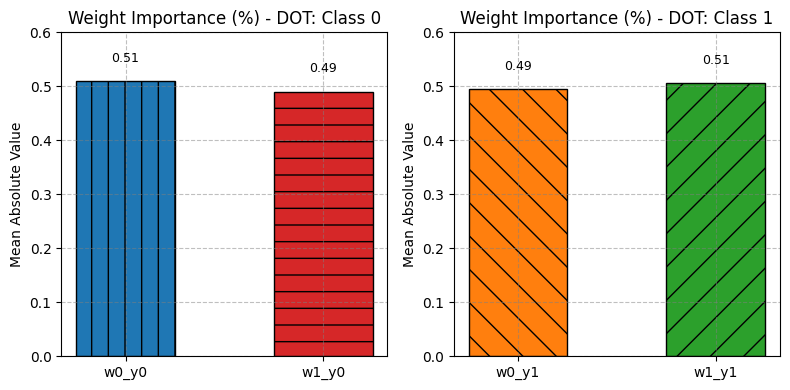

In [104]:
def plotting_function_combined(df0_mean, df1_mean):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

    def softmax(x):
        return np.exp(x) / np.sum(np.exp(x), axis=0)

    def plot_single(ax, df, title, colors, hatches):
        bar_width = 0.5
        bars = ax.bar(df.index, softmax(df), bar_width, color=colors, edgecolor='black')
        
        for bar, hatch in zip(bars, hatches):
            bar.set_hatch(hatch)
        
        ax.set_ylabel('Mean Absolute Value')
        ax.set_title(title)
        ax.grid(True, linestyle='--', which='major', color='gray', alpha=0.5)
        ax.set_ylim([0, 0.6])

        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, yval + 0.03, f'{yval:.2f}', ha='center', va='bottom', fontsize=9, color='black')

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    hatches = ['/', '-', '|', '\\']
    random.shuffle(colors)
    random.shuffle(hatches)

    plot_single(axes[0], df0_mean, "Weight Importance (%) - DOT: Class 0", colors[:2], hatches[:2])
    plot_single(axes[1], df1_mean, "Weight Importance (%) - DOT: Class 1", colors[2:], hatches[2:])

    plt.tight_layout()
    plt.show()


plotting_function_combined(df0_mean[['w0_y0', 'w1_y0']], df1_mean[['w0_y1', 'w1_y1']])

LLR 3

In [105]:
embedding_size = 16
concept_encoder = torch.nn.Sequential(
    torch.nn.Linear(x.shape[1], 16),
    torch.nn.LeakyReLU(),
    te.nn.ConceptEmbedding(16, c.shape[1], embedding_size),
)

task_predictor = IntpLinearLayer3(embedding_size, y.shape[1], bias=isBias)
model = torch.nn.Sequential(concept_encoder, task_predictor)

In [106]:
import os
model.load_state_dict(torch.load(os.path.join(PATH,'model_state_dict_LLR3_DOT_3.pth')))

<All keys matched successfully>

In [66]:
cem = model[0]
llr = model[1]
cem.eval()
llr.eval()
c_emb , c_pred = cem(x)
y_pred, weights, biases = llr(c_emb, c_pred, return_params=True)

In [67]:
y_pred.shape, weights.shape, biases.shape

(torch.Size([10000, 2]), torch.Size([10000, 2, 2]), torch.Size([10000, 2]))

In [68]:
df_all = pd.DataFrame()
df_all['c0'] = c[:,0].detach().numpy()
df_all['c1'] = c[:,1].detach().numpy()
df_all['w0_y0'] = weights[:,0,0].detach().numpy()
df_all['w1_y0'] = weights[:,1,0].detach().numpy()
df_all['w0_y1'] = weights[:,0,1].detach().numpy()
df_all['w1_y1'] = weights[:,1,1].detach().numpy()
df_all['b_y0'] = biases[:,0].detach().numpy()
df_all['b_y1'] = biases[:,1].detach().numpy()
df_all['y0'] = y[:,0].detach().numpy()
df_all['y1'] = y[:,1].detach().numpy()
df_all['y_pred0'] = y_pred[:,0].detach().numpy()
df_all['y_pred1'] = y_pred[:,1].detach().numpy()

In [69]:
temp = df_all[['y_pred0', 'y_pred1']].apply(lambda x: torch.sigmoid(torch.tensor([x[0], x[1]])).numpy(), axis=1).to_numpy()
arr_as_list = [list(sub_array) for sub_array in temp]
arr_converted = np.array(arr_as_list)
column_0 = arr_converted[:, 0]
column_1 = arr_converted[:, 1]

df_all['y_pred0'] = column_0
df_all['y_pred1'] = column_1

In [70]:
df_all.head()

,c0,c1,w0_y0,w1_y0,w0_y1,w1_y1,b_y0,b_y1,y0,y1,y_pred0,y_pred1
0,1.0,0.0,-0.985977,-0.970089,0.986655,0.973135,-1.597925,1.627733,0.0,1.0,0.070183,0.931781
1,1.0,1.0,-0.919426,-0.997498,0.926507,0.997735,-1.235471,1.194399,0.0,1.0,0.041029,0.957622
2,0.0,1.0,0.008102,-0.995613,0.013723,0.995402,-2.045026,2.067101,0.0,1.0,0.045623,0.955319
3,1.0,1.0,0.999896,0.999985,-0.999917,-0.999986,1.987491,-2.138493,1.0,0.0,0.981788,0.015700
4,1.0,0.0,-0.999942,-0.999817,0.999953,0.999881,-3.381819,3.397016,0.0,1.0,0.014480,0.985736


In [71]:
df0= df_all[['c0', 'c1', 'w0_y0', 'w1_y0', 'b_y0']][df_all['y_pred0'] > 0.5]
df1= df_all[['c0', 'c1', 'w0_y1', 'w1_y1', 'b_y1']][df_all['y_pred1'] > 0.5]

In [72]:
df0_mean = df0[['w0_y0', 'w1_y0', 'b_y0']].mean(axis=0)
df0_mean

w0_y0    0.942821
w1_y0    0.866582
b_y0     2.271349
dtype: float32

In [73]:
df1_mean = df1[['w0_y1', 'w1_y1', 'b_y1']].mean(axis=0)
df1_mean

w0_y1    0.549405
w1_y1    0.904653
b_y1     2.504845
dtype: float32

In [74]:
import random
def plotting_function(df_1):

    fig, ax = plt.subplots()

    def softmax(x):
        return np.exp(x) / np.sum(np.exp(x), axis=0)

    # Assuming df_1 is correctly calculated before this snippet
    bar_width = 0.5
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Custom colors for each bar
    colors = random.sample(colors, len(df_1))
    hatches = ['/', '-', '|', '\\']  # Different hatches for each bar
    hatches = random.sample(hatches, len(df_1))
    bars = ax.bar(df_1.index, softmax(df_1), bar_width, color=colors, edgecolor='black')

    for bar, hatch in zip(bars, hatches):
        bar.set_hatch(hatch)
        
    ax.set_ylabel('Mean Absolute Value')
    ax.set_title('Mean Absolute Values of Weights (without Softmax)')
    ax.grid(True, linestyle='--', which='major', color='gray', alpha=0.5)
    ax.set_ylim([0, 0.6])

    # Enhanced label positioning
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.03, f'{yval:.2f}', ha='center', va='bottom', fontsize=9, color='black')

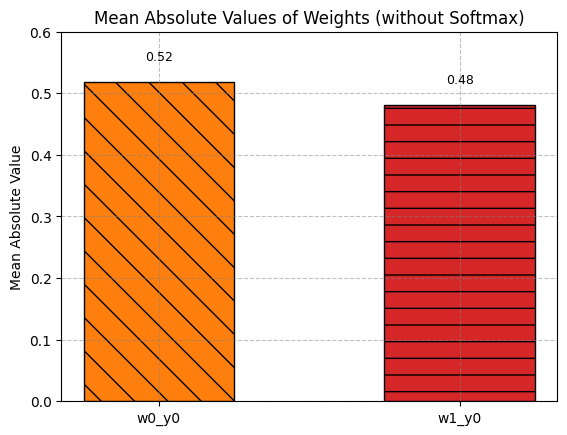

In [75]:
plotting_function(df0_mean[['w0_y0', 'w1_y0']])

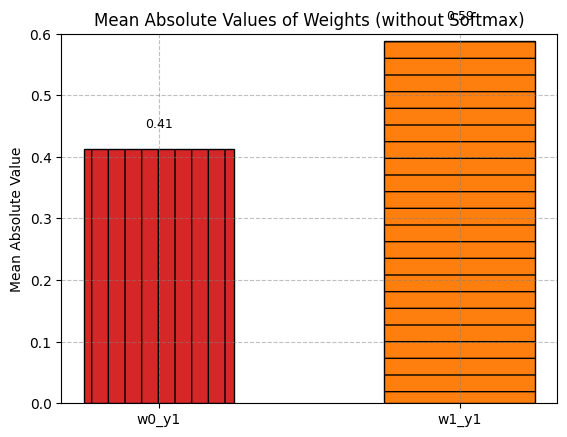

In [76]:
plotting_function(df1_mean[['w0_y1', 'w1_y1']])

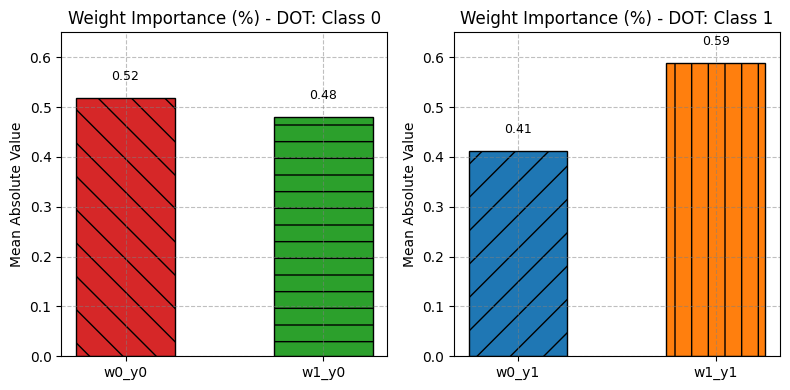

In [81]:
def plotting_function_combined(df0_mean, df1_mean):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

    def softmax(x):
        return np.exp(x) / np.sum(np.exp(x), axis=0)

    def plot_single(ax, df, title, colors, hatches):
        bar_width = 0.5
        bars = ax.bar(df.index, softmax(df), bar_width, color=colors, edgecolor='black')
        
        for bar, hatch in zip(bars, hatches):
            bar.set_hatch(hatch)
        
        ax.set_ylabel('Mean Absolute Value')
        ax.set_title(title)
        ax.grid(True, linestyle='--', which='major', color='gray', alpha=0.5)
        ax.set_ylim([0, 0.65])

        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, yval + 0.03, f'{yval:.2f}', ha='center', va='bottom', fontsize=9, color='black')

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    hatches = ['/', '-', '|', '\\']
    random.shuffle(colors)
    random.shuffle(hatches)

    plot_single(axes[0], df0_mean, "Weight Importance (%) - DOT: Class 0", colors[:2], hatches[:2])
    plot_single(axes[1], df1_mean, "Weight Importance (%) - DOT: Class 1", colors[2:], hatches[2:])

    plt.tight_layout()
    plt.show()


plotting_function_combined(df0_mean[['w0_y0', 'w1_y0']], df1_mean[['w0_y1', 'w1_y1']])

In [78]:
df00= df_all[(df_all['c0'] < 0.5) & (df_all['c1'] < 0.5)]
df01= df_all[(df_all['c0'] < 0.5) & (df_all['c1'] > 0.5)]
df10= df_all[(df_all['c0'] > 0.5) & (df_all['c1'] < 0.5)]
df11= df_all[(df_all['c0'] > 0.5) & (df_all['c1'] > 0.5)]

In [79]:
# concat all Series df00.mean(axis=0), df01.mean(axis=0), df10.mean(axis=0), df11.mean(axis=0) into a DataFrame
df_mean = pd.concat([df00.mean(axis=0), df01.mean(axis=0), df10.mean(axis=0), df11.mean(axis=0)], axis=1)
df_mean.columns = ['00', '01', '10', '11']
df_mean = df_mean.T

In [80]:
df_mean.round(3)

,c0,c1,w0_y0,w1_y0,w0_y1,w1_y1,b_y0,b_y1,y0,y1,y_pred0,y_pred1
00,0.0,0.0,0.690,0.417,-0.686,-0.395,1.656,-1.646,0.757,0.243,0.734,0.267
01,0.0,1.0,0.145,-0.504,-0.136,0.502,-1.523,1.522,0.248,0.752,0.265,0.735
10,1.0,0.0,-0.523,-0.461,0.525,0.476,-1.577,1.557,0.238,0.762,0.257,0.742
11,1.0,1.0,0.479,0.473,-0.477,-0.472,0.971,-0.955,0.747,0.253,0.734,0.266
